In [1]:
import torch
import matplotlib.pyplot as plt
from dataloader import MRIDataset
from residual3dunet.model import ResidualUNet3D
from torch.utils.data import Dataset, DataLoader
from utils import dice_coefficient, iou, plotloss, plotaccuracy, compute_average
import torchvision.transforms as T
import nibabel as nib
import numpy as np

<Figure size 432x288 with 0 Axes>

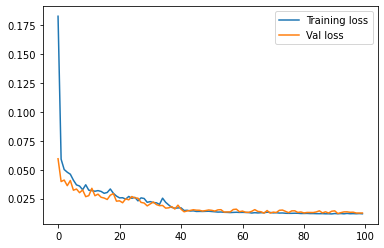

<Figure size 432x288 with 0 Axes>

In [2]:
plotloss('output/train15.out')
plt.figure()
# plotaccuracy('output/train6.out')


In [3]:
device = torch.device('cpu')
model = ResidualUNet3D(in_channels=1, out_channels=1, testing=True).to(device)

# model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load("model/model11.pt", map_location=device))

<All keys matched successfully>

In [4]:
testdataset = MRIDataset(train=False, transform=T.ToTensor())
test_loader = DataLoader(dataset = testdataset, batch_size=1, shuffle=False)

image_path = './dataset/train/T1/MRI1_T1.nii.gz'
image_obj = nib.load(image_path)

# Extract data as numpy array
image_data = image_obj.get_fdata()

image_data = np.pad(image_data, ((0,0),(0,0),(0,1)))
image_data = np.moveaxis(image_data, 2, 0)
image_data = np.moveaxis(image_data, 2, 1)
image_data = torch.from_numpy(image_data)
image_data = torch.unsqueeze(image_data, 0)
image_data = torch.unsqueeze(image_data, 0)
print(image_data.shape)

torch.Size([1, 1, 14, 240, 240])


In [5]:
model.eval()

dataiter = iter(test_loader)
data = dataiter.next()
data = dataiter.next()
data = dataiter.next()
features, labels = data

features, labels = features.float().to(device), labels.float().to(device)

# image_data = image_data.float().to(device)

output = model(features)

torch.Size([1, 32, 14, 240, 240])
torch.Size([1, 64, 14, 120, 120])
torch.Size([1, 128, 14, 60, 60])
torch.Size([1, 256, 14, 30, 30])
torch.Size([1, 512, 14, 15, 15])
torch.Size([1, 256, 14, 30, 30])
torch.Size([1, 128, 14, 60, 60])
torch.Size([1, 64, 14, 120, 120])
torch.Size([1, 32, 14, 240, 240])
torch.Size([1, 1, 14, 240, 240])


In [6]:
# preds = torch.sigmoid(output)
preds = (output > 0.5).float()

print(preds.shape)
batch, channel, depth, width, height = preds.shape

print(dice_coefficient(preds, labels))
print(iou(preds, labels))

torch.Size([1, 1, 14, 240, 240])
tensor(0.9316)
tensor(0.8720)


In [ ]:
# Visualize Single Image Data
f, axarr = plt.subplots(14,3,figsize=(50,50))

for i in range(depth):
    axarr[i,0].imshow(image_data[0,0,i,:,:],cmap='gray')
    axarr[i,1].imshow(preds[0,0,i,:,:],cmap='gray')
    axarr[i,2].imshow(labels[0,0,i,:,:],cmap='gray')
    plt.axis('off')

In [7]:
from segmentation_statistics import SegmentationStatistics

preds = preds.numpy()
labels = labels.numpy()
preds = preds.astype(bool)
labels = labels.astype(bool)

# preds = preds.bool()
# labels = labels.bool()

stat = SegmentationStatistics(preds[0,0,:,:,:], labels[0,0,:,:,:], (3,2,1))

In [24]:
import pandas as pd
yeet = []
yeet.append(stat.to_dict())
yeet.append(stat.to_dict())
yeet.append(stat.to_dict())
yeet.append(stat.to_dict())
# type(stat)

df = compute_average(yeet,dataframe=True)
df


,Metric,Score
0,Dice,0.931607
1,Jaccard,0.871970
2,Sensitivity,0.903268
3,Specificity,0.998558
4,Precision,0.961782
5,Accuracy,0.994877
6,Mean_Surface_Distance,0.526067
7,Hausdorff_Distance,3.000000
8,Volume_Difference,-11.370000
